# DataUp

Proyecto del curso "Taller de Proyecto". Análisis de entrevistas utilizando procesamiento de voz y técnicas de análisis de texto

In [4]:
#Imports
#Genericas.
import numpy as np
import pandas as pd
from os import path
import matplotlib.pyplot as plt
#Reconocimiento de voz.
import speech_recognition as sr
#import pyaudio
#Procesamiento de texto.
import re
#Procesamiento de lenguaje natural.
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer


## 1.- Procesamiento de Voz

In [23]:
#Captura 
def capturaAudio(tiempoEspera = 5):
    r = sr.Recognizer()
    with sr.Microphone() as source:
        #Ajuste a piso de ruido.
        r.adjust_for_ambient_noise(source)
        print('Comience el audio')
        #Iniciar escucha.
        audio = r.listen(source, timeout = tiempoEspera)
        try:
            # for testing purposes, we're just using the default API key
            # to use another API key, use `r.recognize_google(audio, key="GOOGLE_SPEECH_RECOGNITION_API_KEY")`
            # instead of `r.recognize_google(audio)`
            texto = r.recognize_google(audio,language="es-CL")
            print("Google Speech Recognition thinks you said " + texto)
        except sr.UnknownValueError:
            print("Google Speech Recognition could not understand audio")
        except sr.RequestError as e:
            print("Could not request results from Google Speech Recognition service; {0}".format(e))
        print ('Termino de audio')
        
        return texto

In [24]:
audioPrueba = capturaAudio(15)

Comience el audio
Google Speech Recognition thinks you said burbujas burbujas burbujas burbujas burbujas
Termino de audio


In [7]:
audioPrueba

'muy bien Igual al encuestado vino que la bebida tenía un dulzor de aproximadamente 5 casino amargura 11 y agrogeo un 10'

In [8]:
#texto1 = "Dulzor, 5; Amargor, 1; Burbujas; 10",
texto2 = "El encuestado opino que la bebida tenia un dulzor de aproximadamente cinco ; asigno a amargura un 1 y a burbujeo un diez"
#audioPrueba = texto2

## 2.- Análisis del Texto

### 2.1.- Pre-procesamiento

#### 2.1.1.- Eliminacion de stopwords y ruido

Removing stopwords: Stop words include the large number of prepositions, pronouns, conjunctions etc in sentences. These words need to be removed before we analyse the text, so that the frequently used words are mainly the words relevant to the context and not common words used in the text.

In [9]:
#Lista de stop words en espanol. Util para elminaras del texto original.
stopWords = set(stopwords.words("spanish"))

In [10]:
def pasoPanda(texto):
    output = pd.DataFrame([texto],columns = ['Texto'], index = [1])
    return output

def preProcesamiento(textoPandas,stopWords, deleteStopWords = 1, lemanizar= 0):
    #Funcion que realiza el preProcesamiento del texto.
    
    #Convertir a Pandas.
    text = textoPandas['Texto'][1]
    #Pasar a minusculas.
    text = text.lower()
    #Eliminar comas y simbolos.
    text = re.sub(r'[^\w\s]','',text)
    #Convertir a vector de palabras.
    text = text.split()
    #Eliminar stopWords
    text = [word for word in text if not word in stopWords]
    #Decidir si lemanizar o no
    if lemanizar == 1:
        lem = WordNetLemmatizer()
        text = np.array([lem.lemmatize(word) for word in text])
    elif lemanizar == 2:
        stem = PorterStemmer()
        text = np.array([stem.stem(word) for word in text])
    return text

In [11]:
#Funcion que pase de numeros en palabras a en digitos.
def text2int (textnum, numwords={}):
    if not numwords:
        units = [
        "cero", "uno", "dos", "tres", "cuatro", "cinco", "seis", "siete", "ocho",
        "nueve", "diez", "once", "doce"]

        diccionario = {units[0]:0,units[1]:1,units[2]:2,units[3]:3,units[4]:4,units[5]:5, units[6]:6, units[7]:7,units[8]:8,units[9]:9,units[10]:10,units[11]:11,units[12]:12}
    
    copiaTextNum = textnum;
    count = 0
    for word in copiaTextNum:
        if word not in units:
            count += 1
        else:
            copiaTextNum[count] = str(diccionario[word]);
            count += 1

    return copiaTextNum

In [12]:
#audioPrueba = text2int(audioPrueba)
#Paso del audio a textoPanda
texto = pasoPanda(audioPrueba)
#text2int(audioPrueba)

In [13]:
#Generar el texto preProcesado. Se entrega un vector con las palabras clave.
textPre = preProcesamiento(texto,stopWords,lemanizar=0)

#### 2.1.2 Homologar sinonimos.

Se pasan los sinonimos de las características a estudiar a para realizar un adecuado procesamiento del texto y encontrar las calificaciones indicadas por l@s usuari@s.

In [14]:
#Generación del diccionario. Diccionario de las características que mediremos.
sinonimosDulce = ['dulce','dulzón', 'azucarado', 'acaramelado', 'dulcificado','dulzor']
sinonimosAmargo = ['amargo', 'agrio', 'aspero','amargor','agriedad','amargura']
sinonimosBurbujas = ['burbujas', 'burbujeo', 'efervescencia', 'espuma', 'efervescente', 'burbujeo', 'burbujear']

In [15]:
def homologarSinonimosUnaPalabra(vectorTexto,sinonimos):
    #Numero de palabras de la grabación.
    numeroPalabras = len(vectorTexto)
    #Casos para cada palabra
    count = 0
    while count < numeroPalabras:
        if vectorTexto[count] in sinonimos:
            vectorTexto[count] = sinonimos[0]
        count += 1
    return vectorTexto    

def homologarSinonimos(texto):
    #Metodo que realice el cambio de palabras para las caracteristicas de interes.
    texto = homologarSinonimosUnaPalabra(texto,sinonimosDulce)
    texto = homologarSinonimosUnaPalabra(texto,sinonimosAmargo)
    texto = homologarSinonimosUnaPalabra(texto,sinonimosBurbujas)
    return texto

In [16]:
textoPre = homologarSinonimos(textPre)
textoPre

['bien',
 'igual',
 'encuestado',
 'vino',
 'bebida',
 'dulce',
 'aproximadamente',
 '5',
 'casino',
 'amargo',
 '11',
 'agrogeo',
 '10']

In [17]:
text2int(textoPre)

['bien',
 'igual',
 'encuestado',
 'vino',
 'bebida',
 'dulce',
 'aproximadamente',
 '5',
 'casino',
 'amargo',
 '11',
 'agrogeo',
 '10']

### 2.2 Búsquedad de calificaciones

In [18]:
def stringNumerico (word):
    #Funcion que verifica si un string es numerico
    try:
        val = int(word)
        output = True
    except ValueError:
        output = False
    return output

#Funcion que realiza la busqueda de la calificacion.
def buscarValorAsociado(caracteristica, vectorTexto):
    indiceCaracteristica = np.where(vectorTexto == caracteristica)
    calificacion = int(vectorTexto[indiceCaracteristica[0]+1])
    return calificacion

In [19]:
def buscarDespues(indiceCar,vecCaracteristicas,text,maxVentana):
    #Funcion que realiza busqueda hacia adelante.
    
    #Entregables.
    cond = False;
    calificacion = 'NS/NR'
    #Valores de indice.
    valoresIndice = np.arange(indiceCar+1,indiceCar+maxVentana)
    #Largo del texto.
    largoTexto = text.shape[0]
    #Ciclo de busqueda
    for indice in valoresIndice:
        if (indice >= largoTexto):
            #Caso en que el indice supere el largo del texto.
            break
        elif (text[indice] in vecCaracteristicas):
            #Caso en que se encuentre con otra caracteristica.
            break
        else:
            #Caso en que la palabra no es una caracteristica.
            if (stringNumerico(text[indice])):
                #Caso en que el string es un string numerico.
                cond = True
                calificacion = int(text[indice])
                break
                
    return cond,calificacion

def buscarAntes(indiceCar,vecCaracteristicas,text,maxVentana):
    #Funcion que realiza busqueda hacia adelante.
    
    #Entregables.
    cond = False;
    calificacion = 'NS/NR'
    #Valores de indice.
    indiceFinal = indiceCar-maxVentana
    valoresIndice = np.arange(indiceCar-1,indiceFinal, -1)
    #Ciclo de busqueda
    for indice in valoresIndice:
        if (indice < 0):
            #Caso en que el indice llegue a valores negativos.
            break
        elif (text[indice] in vecCaracteristicas):
            #Caso en que se encuentre con otra caracteristica.
            break
        else:
            #Caso en que la palabra no es una caracteristica.
            if (stringNumerico(text[indice])):
                #Caso en que el string es un string numerico.
                cond = True
                calificacion = int(text[indice])
                break
                
    return cond,calificacion
    
def buscarCalificacion(caracteristica,vecCaracteristicas,texto,maxVentana = 3):
    #Funcion que busque la calificacion asociada a una caracteristica.
    
    #Pasar a arreglo de numpy.
    text = np.array(texto)
    #Buscar la/las posicion/posiciones de la característica.
    indices = np.where(text==caracteristica);
    for indiceCar in indices:
        cond,calificacion = buscarDespues(indiceCar,vecCaracteristicas,text,maxVentana)
        if (cond):
            break
        else:
            cond,calificacion = buscarAntes(indiceCar,vecCaracteristicas,text,maxVentana)
            if(cond):
                break
    return calificacion

def buscarCalificaciones(vectorCaracteristicas,texto, maxVentana = 3):
    #Funcion que busque las relaciones entre las caracteristicas y sus calificaciones.
    
    #Vector de calificaciones a almacenar.
    vecCalificaciones = np.array([])
    
    for caracteristica in vectorCaracteristicas:
        #Buscar la calificacion.
        calif = buscarCalificacion(caracteristica,vectorCaracteristicas,texto,maxVentana)
        #Agregar la calificacion al vector,
        vecCalificaciones = np.append(vecCalificaciones,calif)
    return vectorCaracteristicas, vecCalificaciones

In [20]:
caracts,califs = buscarCalificaciones(['dulce','amargo','burbujas'],textoPre,maxVentana = 3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
print(caracts,califs)

In [43]:
len(caracts)

3

## 3.- Visualización rápida

In [44]:
def agregarValor(caracteristicas,calificaciones):
    #Funcion que genere una lista de strings con caracteristica y calificacion para la visualizacion de la informacion.
    
    #Vector vacio.
    vecGraph = np.array([]);
    #Ir concatenando.
    count = 0
    for caracteristica in caracteristicas:
        agregar = caracteristica + '(' + str(calificaciones[count]) +')'
        vecGraph = np.append(vecGraph,agregar)
        count += 1;
    return vecGraph

In [45]:
def visualizacion(caracteristicas, calificaciones):
    #Visualizacion rapida de caracteristicas
    
    #Numero de calificaciones.
    AttNo = len(caracteristicas)
    #Generacion del grafico.
    ax = plt.subplot(111, polar = True)
    #Definicion de los angulos.
    angles = [n / float(AttNo) * 2 * np.pi for n in range(AttNo)]
    angles += angles [:1]
    #
    calificaciones = np.append(calificaciones,calificaciones[:1])
    #Agregar los atributos al grafico.
    #Agregar valor al atributo.
    car = agregarValor(caracteristicas,calificaciones)
    plt.xticks(angles,car)
    #
    ax.plot(angles,calificaciones)
    #
    #Fill in the area plotted in the last line
    ax.fill(angles, calificaciones, 'teal', alpha=0.1)
    #Titulo.
    ax.set_title("Resultados encuesta")
    plt.show()

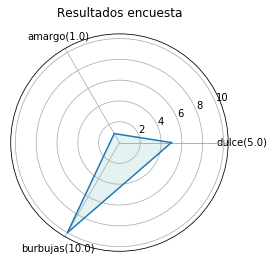

In [46]:
 visualizacion(caracts,califs)